In [1]:
import sys
sys.path.append("../../../")
from ise.visualization import Plotter
from ise.models.testing.pretrained import binned_sle_table
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
from matplotlib.ticker import ScalarFormatter, AutoMinorLocator
from ise.utils.data import (
    create_distribution,
    kl_divergence,
    js_divergence
)
from itertools import product
import random
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

true_color = '#66c2a5'
nn_color = '#fc8d62'
gp_color = '#8da0cb'

mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['font.size'] = 15
mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['figure.figsize'] = 7.2,4.45
# mpl.rcParams['axes.titlesize '] = 16
# mpl.rcParams['axes.labelsize '] = 17
# mpl.rcParams['lines.linewidth '] = 2
# mpl.rcParams['lines.markersize '] = 6
mpl.rcParams['legend.fontsize'] = 13
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

/users/pvankatw/anaconda/emulator/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = pd.read_csv(r'../nn_results.csv')
gp_data = pd.read_csv(r'../gp_results.csv')

preds = gp_data['preds']
std = gp_data['std']
dataset['gp_pred'] = preds  # + dataset.ctrl_sle
dataset['gp_std'] = std
dataset['gp_mse'] = abs(dataset.gp_pred - dataset.true)**2
dataset['gp_mae'] = abs(dataset.gp_pred - dataset.true)

In [3]:
data = dataset[['true', 'pred', 'sd', 'gp_pred', 'gp_std', 'exp_id', 'modelname', 'sectors', 'year']]
reduced_single = pd.read_csv(r'1_reduced.csv')
data['reduced_single_pred'], data['reduced_single_sd'] = reduced_single['preds'], reduced_single['sd']
reduced_multiple = pd.read_csv(r'85_reduced.csv')
data['reduced_multiple_pred'], data['reduced_multiple_sd'] = reduced_multiple['preds'], reduced_multiple['std']
full_multiple = pd.read_csv(r'85_full.csv')
data['full_multiple_pred'], data['full_multiple_sd'] = full_multiple['preds'], full_multiple['std']

In [4]:
def group_by_run(dataset: pd.DataFrame, column: str=None, condition: str=None,):
    """Groups the dataset into each individual simulation series by both the true value of the 
    simulated SLE as well as the model predicted SLE. The resulting arrays are NXM matrices with
    N being the number of simulations and M being 85, or the length of the series.

    Args:
        dataset (pd.DataFrame): Dataset to be grouped
        column (str, optional): Column to subset on. Defaults to None.
        condition (str, optional): Condition to subset with. Can be int, str, float, etc. Defaults to None.
        
    Returns:
        tuple: Tuple containing [all_trues, all_preds], or NXM matrices of each series corresponding to true values and predicted values.
    """

    modelnames = dataset.modelname.unique()
    exp_ids = dataset.exp_id.unique()
    sectors = dataset.sectors.unique()

    all_runs = [list(i) for i in list(product(modelnames, exp_ids, sectors))]

    all_trues = []
    all_preds = []
    scenarios = []
    all_gp = []
    all_std = []
    reduced_multiple = []
    reduced_single = []
    full_multiple = []
    for i, run in enumerate(all_runs):
        modelname = run[0]
        exp = run[1]
        sector = run[2]
        if column is None and condition is None:
            subset = dataset[(dataset.modelname == modelname) & (dataset.exp_id == exp) & (dataset.sectors == sector)]
        elif column is not None and condition is not None:
            subset = dataset[(dataset.modelname == modelname) & (dataset.exp_id == exp) & (dataset.sectors == sector) & (dataset[column] == condition)]
        else:
            raise ValueError('Column and condition type must be the same (None & None, not None & not None).')
        if not subset.empty:
            scenarios.append([modelname, exp, sector])
            all_trues.append(subset.true.to_numpy())
            all_preds.append(subset.pred.to_numpy())
            all_gp.append(subset.gp_pred.to_numpy())
            all_std.append(subset.gp_pred.to_numpy())
            reduced_multiple.append(subset.reduced_multiple_pred.to_numpy())
            reduced_single.append(subset.reduced_single_pred.to_numpy())
            full_multiple.append(subset.full_multiple_pred.to_numpy()) 
            
            
            
    return np.array(all_trues), np.array(all_preds), scenarios, np.array(all_gp), np.array(all_std), np.array(reduced_multiple), np.array(reduced_single), np.array(full_multiple)

def get_uncertainty_bands(data: pd.DataFrame, confidence: str='95', quantiles: list[float]=[0.05, 0.95]):
    """Calculates uncertainty bands on the monte carlo dropout protocol. Includes traditional 
    confidence interval calculation as well as a quantile-based approach.

    Args:
        data (pd.DataFrame): Dataframe or array of NXM, typically from ise.utils.data.group_by_run.
        confidence (str, optional): Confidence level, must be in [95, 99]. Defaults to '95'.
        quantiles (list[float], optional): Quantiles of uncertainty bands. Defaults to [0.05, 0.95].

    Returns:
        tuple: Tuple containing [mean, sd, upper_ci, lower_ci, upper_q, lower_q], or the mean prediction, standard deviation, and the lower and upper confidence interval and quantile bands.
    """
    z = {'95': 1.96, '99': 2.58}
    data = np.array(data)
    mean = data.mean(axis=0)
    sd = np.sqrt(data.var(axis=0))
    upper_ci = mean + (z[confidence] * (sd/np.sqrt(data.shape[0])))
    lower_ci = mean - (z[confidence] * (sd/np.sqrt(data.shape[0])))
    quantiles = np.quantile(data, quantiles, axis=0)
    upper_q = quantiles[1,:]
    lower_q = quantiles[0,:]
    return mean, sd, upper_ci, lower_ci, upper_q, lower_q

In [5]:
all_trues, all_preds, scenarios, all_gp, all_std, all_red_mul, all_red_sing, all_full_mul = group_by_run(data)

mean_true, true_sd, true_upper_ci, true_lower_ci, true_upper_q, true_lower_q = get_uncertainty_bands(all_trues,)
mean_pred, pred_sd, pred_upper_ci, pred_lower_ci, pred_upper_q, pred_lower_q = get_uncertainty_bands(all_preds,)
mean_gp, gp_sd, gp_upper_ci, gp_lower_ci, gp_upper_q, gp_lower_q = get_uncertainty_bands(all_gp,)
mean_red_mul, red_mul_sd, red_mul_upper_ci, red_mul_lower_ci, red_mul_upper_q, red_mul_lower_q = get_uncertainty_bands(all_red_mul,)
mean_red_sing, red_sing_sd, red_sing_upper_ci, red_sing_lower_ci, red_sing_upper_q, red_sing_lower_q = get_uncertainty_bands(all_red_sing,)
mean_full_mul, full_mul_sd, full_mul_upper_ci, full_mul_lower_ci, full_mul_upper_q, full_mul_lower_q = get_uncertainty_bands(all_full_mul,)

true_df = pd.DataFrame(all_trues).transpose()
pred_df = pd.DataFrame(all_preds).transpose()
gp_df = pd.DataFrame(all_gp).transpose()
std_df = pd.DataFrame(all_std).transpose()
red_mul_df = pd.DataFrame(mean_red_mul).transpose()
red_sing_df = pd.DataFrame(mean_red_sing).transpose()
full_mul_df = pd.DataFrame(mean_full_mul).transpose()

year = 2100
true_dist, true_support = create_distribution(year=year, dataset=all_trues)
pred_dist, pred_support = create_distribution(year=year, dataset=all_preds)
gp_dist, gp_support = create_distribution(year=year, dataset=all_gp)
red_mul_dist, red_mul_support = create_distribution(year=year, dataset=all_red_mul)
red_sing_dist, red_sing_support = create_distribution(year=year, dataset=all_red_sing)
full_mul_dist, full_mul_support = create_distribution(year=year, dataset=all_full_mul)

In [6]:
sector_year = pd.DataFrame(data.groupby(by=['sectors', 'year']).mean())
summed = sector_year.groupby(by='year').sum()
summed

,true,pred,sd,gp_pred,gp_std,reduced_single_pred,reduced_single_sd,reduced_multiple_pred,reduced_multiple_sd,full_multiple_pred,full_multiple_sd
year,,,,,,,,,,,
2016,0.678515,1.064826,3.235915,0.515983,6.429564,0.845475,2.423979,0.502131,0.631532,0.525856,0.683671
2017,0.667178,1.354573,2.566704,0.425751,6.943534,0.388378,1.031843,0.603262,0.627479,0.861865,0.883790
2018,0.649005,1.025283,2.530431,0.426256,7.267571,-0.330890,1.297293,-0.040822,0.599278,0.515285,0.943920
2019,0.866865,1.106527,2.512867,0.615446,7.455283,-2.406551,2.227346,0.869808,0.546382,0.757930,0.882334
2020,1.076207,0.972234,2.187152,0.706005,7.176331,0.276341,1.714112,0.658526,0.606448,0.798552,0.972144
...,...,...,...,...,...,...,...,...,...,...,...
2096,13.322108,12.255250,10.889838,8.788017,54.373035,10.939806,7.451633,8.912471,5.992923,11.075414,9.837405
2097,13.257201,12.490311,11.094109,8.684670,55.938602,10.812970,7.640410,8.484693,5.475779,8.578734,9.521296
2098,13.274887,12.561740,11.276383,8.586895,57.690839,10.835879,7.713273,10.381383,5.608047,9.824229,10.639315


In [7]:
rolled_gp = summed['gp_pred'].rolling(3).mean()
rolled_gp[:3] = summed['gp_pred'][:3]

rolled_red_mul = summed['reduced_multiple_pred'].rolling(3).mean()
rolled_red_mul[:3] = summed['reduced_multiple_pred'][:3]

rolled_full_mul = summed['full_multiple_pred'].rolling(3).mean()
rolled_full_mul[:3] = summed['full_multiple_pred'][:3]

rolled_red_sing = summed['reduced_single_pred'].rolling(3).mean()
rolled_red_sing[:3] = summed['reduced_single_pred'][:3]

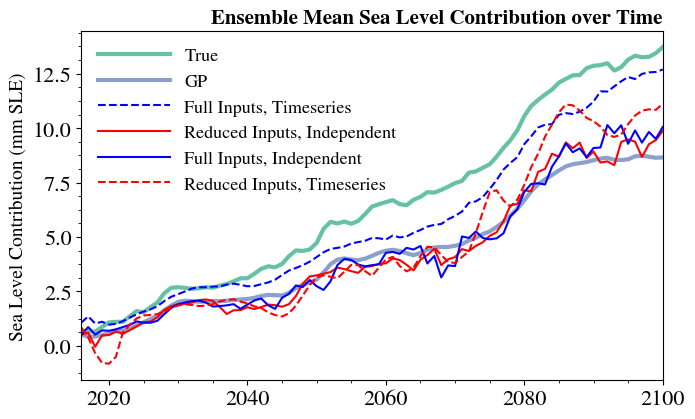

In [8]:
fig, ax = plt.subplots()
plt.plot(np.arange(2016, 2101), summed['true'], label='True', color=true_color, linewidth=3)
plt.plot(np.arange(2016, 2101), rolled_gp, label='GP', color=gp_color, linewidth=3)
plt.plot(np.arange(2016, 2101), summed['pred'], label='Full Inputs, Timeseries', color='blue', linestyle='--')
plt.plot(np.arange(2016, 2101), rolled_red_mul, label='Reduced Inputs, Independent', color='red')
plt.plot(np.arange(2016, 2101), rolled_full_mul, label='Full Inputs, Independent', color='blue')
plt.plot(np.arange(2016, 2101), rolled_red_sing, label='Reduced Inputs, Timeseries', color='red', linestyle='--')
plt.title('Ensemble Mean Sea Level Contribution over Time', {'fontsize': 'medium', 'weight': 650}, loc='right')
plt.ylabel('Sea Level Contribution (mm SLE)', {'fontsize': 14})
# plt.xlabel('Year', )

ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_minor_locator(  AutoMinorLocator(4))
ax.xaxis.set_minor_locator(  AutoMinorLocator(4))
ax.legend(frameon=False, loc='upper left',ncol=1,handlelength=4)
ax.set_xlim([2016, 2100])
# plt.savefig('mean.png', dpi=800)
plt.show()

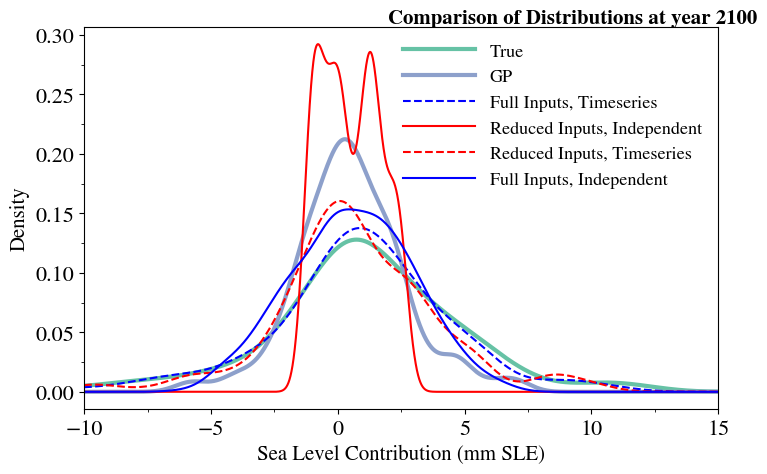

In [9]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(true_support, true_dist, label="True", color=true_color, linewidth=3)
ax.plot(true_support, gp_dist, label="GP", color=gp_color, linewidth=3)
ax.plot(pred_support, pred_dist, label="Full Inputs, Timeseries", color='blue', linestyle='--')
ax.plot(red_mul_support, red_mul_dist, label="Reduced Inputs, Independent", color='red')
ax.plot(red_sing_support, red_sing_dist, label="Reduced Inputs, Timeseries", color='red', linestyle='--')
ax.plot(full_mul_support, full_mul_dist, label="Full Inputs, Independent", color='blue')


ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_minor_locator(  AutoMinorLocator(2))
ax.xaxis.set_minor_locator(  AutoMinorLocator(2))
ax.text(2, .31, f'Comparison of Distributions at year {year}', {'weight': 700})

ax.set_xlabel("Sea Level Contribution (mm SLE)")
ax.set_ylabel("Density")
ax.legend(frameon=False, loc='upper right',ncol=1,handlelength=4)
ax.set_xlim([-10, 15])

# plt.savefig('distributions.png', dpi=800)

plt.show()

In [10]:
m = {
    "Full Inputs, Timeseries": [np.mean((data.true - data.pred)**2), r2_score(data.true, data.pred), kl_divergence(pred_dist, true_dist)],
    "Reduced, Timeseries": [np.mean((data.true - data.reduced_single_pred)**2), r2_score(data.true, data.reduced_single_pred), kl_divergence(red_sing_dist, true_dist)],
    "Full, Independent": [np.mean((data.true - data.full_multiple_pred)**2), r2_score(data.true, data.full_multiple_pred), kl_divergence(full_mul_dist, true_dist)],
    "Reduced, Independent": [np.mean((data.true - data.reduced_multiple_pred)**2), r2_score(data.true, data.reduced_multiple_pred), kl_divergence(red_mul_dist, true_dist)],
    "GP": [np.mean((data.true - data.gp_pred)**2), r2_score(data.true, data.gp_pred), kl_divergence(gp_dist, true_dist)],
    
}
pd.DataFrame(m, index=['MSE', 'R2', 'KL Div',])

,"Full Inputs, Timeseries","Reduced, Timeseries","Full, Independent","Reduced, Independent",GP
MSE,1.011355,2.135891,3.252068,4.044997,2.070138
R2,0.777241,0.529552,0.283705,0.109055,0.544035
KL Div,18.132596,56.162951,154.246038,667.511249,199.137813


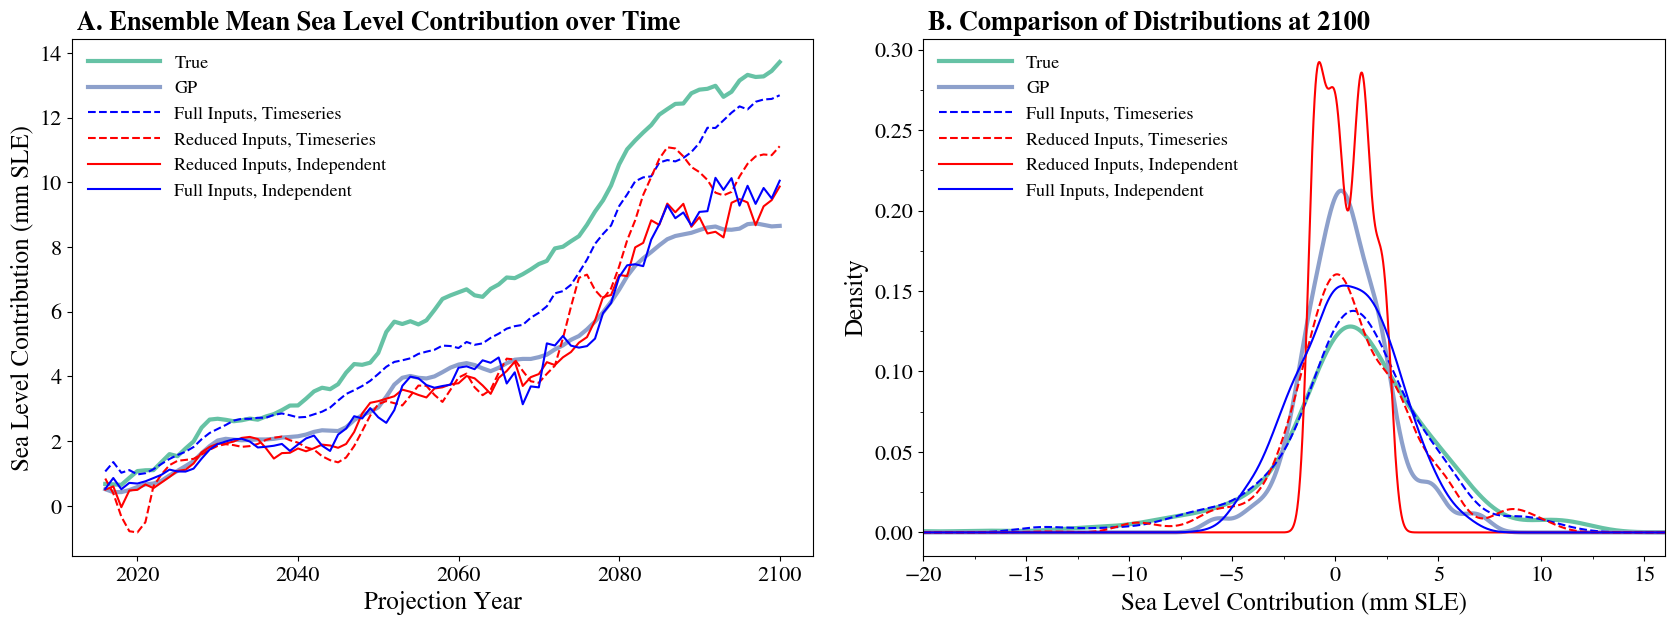

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(17, 6.5), sharey=False, sharex=False)

axs[0].plot(np.arange(2016, 2101), summed['true'], label='True', color=true_color, linewidth=3)
axs[0].plot(np.arange(2016, 2101), rolled_gp, label='GP', color=gp_color, linewidth=3)
axs[0].plot(np.arange(2016, 2101), summed['pred'], label='Full Inputs, Timeseries', color='blue', linestyle='--')
axs[0].plot(np.arange(2016, 2101), rolled_red_sing, label='Reduced Inputs, Timeseries', color='red', linestyle='--')
axs[0].plot(np.arange(2016, 2101), rolled_red_mul, label='Reduced Inputs, Independent', color='red')
axs[0].plot(np.arange(2016, 2101), rolled_full_mul, label='Full Inputs, Independent', color='blue')
# axs[0].title('Ensemble Mean Sea Level Contribution over Time', {'fontsize': 'medium', 'weight': 650}, loc='right')
axs[0].set_ylabel('Sea Level Contribution (mm SLE)', {'fontsize': 18})

axs[1].plot(true_support, true_dist, label="True", color=true_color, linewidth=3)
axs[1].plot(true_support, gp_dist, label="GP", color=gp_color, linewidth=3)
axs[1].plot(pred_support, pred_dist, label="Full Inputs, Timeseries", color='blue', linestyle='--')
axs[1].plot(red_sing_support, red_sing_dist, label="Reduced Inputs, Timeseries", color='red', linestyle='--')
axs[1].plot(red_mul_support, red_mul_dist, label="Reduced Inputs, Independent", color='red')
axs[1].plot(full_mul_support, full_mul_dist, label="Full Inputs, Independent", color='blue')

axs[1].yaxis.set_major_formatter(ScalarFormatter())
axs[1].yaxis.set_minor_locator(  AutoMinorLocator(2))
axs[1].xaxis.set_minor_locator(  AutoMinorLocator(2))

# ax.text(-31, .41, f"NN KLD: {kl_divergence(pred_dist, true_dist):0.3f}")
# ax.text(-31, .41 - (.41-.38), f"GP KLD: {kl_divergence(gp_dist, true_dist):0.3f}")

axs[0].text(2012.5, 14.75, 'A. Ensemble Mean Sea Level Contribution over Time', {'fontsize': 19, 'weight': 550})
axs[1].text(-19.75, 0.3125, 'B. Comparison of Distributions at 2100', {'fontsize': 19, 'weight': 550})
# axs[0].text(2016.5, 15.5, title1, {'fontsize': 18, 'weight': 550})

axs[1].set_xlabel("Sea Level Contribution (mm SLE)", {'fontsize': 18})
axs[0].set_xlabel("Projection Year", {'fontsize': 18})
axs[1].set_ylabel("Density", {'fontsize': 18})
axs[1].legend(frameon=False, loc='upper left',ncol=1,handlelength=4)
axs[0].legend(frameon=False, loc='upper left',ncol=1,handlelength=4)
axs[1].set_xlim([-20, 16])

# plt.savefig('ablation.png',)

plt.show()